# Mini-Project: Computing the Permanent with Monte Carlo Methods

**STAN48 - Programming for Data Science**

This notebook demonstrates how Monte Carlo methods and variance reduction transform an intractable problem into a solvable one.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import permutations
import time
np.random.seed(222)


## 1. The Permanent: Definition and Naive Computation

The permanent of an n×n matrix is like the determinant, but without alternating signs:

$$\text{perm}(A) = \sum_{\sigma \in S_n} \prod_{i=1}^{n} A_{i,\sigma(i)}$$

In [3]:
def permanent_exact(A):
    """Compute permanent exactly (only feasible for small matrices)"""
    n = len(A)
    total = 0
    for perm in permutations(range(n)):
        product = 1
        for i in range(n):
            product *= A[i][perm[i]]
        total += product
    return total

# Test on small matrices
A_tiny = np.array([[1, 2], 
                   [3, 4]])
print(f"2 by 2 matrix permanent: {permanent_exact(A_tiny)}")
print(f"Compare to determinant: {np.linalg.det(A_tiny):.0f}")

2 by 2 matrix permanent: 10
Compare to determinant: -2


## 2. The Computational Challenge

Let's see how computation time explodes with matrix size:

In [4]:
# Measure computation time for different sizes
sizes = [2, 3, 4, 5, 6, 7, 8]
times = []

for n in sizes:
    A = np.random.rand(n, n)
    start = time.time()
    permanent_exact(A)
    elapsed = time.time() - start
    times.append(elapsed)
    print(f"n={n}: {elapsed:.4f}s ({math.factorial(n):,} permutations)")
    if elapsed > 1:  # Stop if it takes too long
        break



n=2: 0.0000s (2 permutations)
n=3: 0.0000s (6 permutations)
n=4: 0.0000s (24 permutations)
n=5: 0.0001s (120 permutations)
n=6: 0.0007s (720 permutations)
n=7: 0.0053s (5,040 permutations)
n=8: 0.0493s (40,320 permutations)


## 3. Naive Monte Carlo Solution

Instead of checking all n! permutations, we randomly sample some and estimate:

$$\text{perm}(A) \approx n! \times \text{(average value of sampled permutations)}$$

In [ ]:
def permanent_naive_mc(A, n_samples=10000):
    """Naive Monte Carlo estimation"""
    n = len(A)
    estimates = []
    
    for _ in range(n_samples):
        # Random permutation
        perm = np.random.permutation(n)
        #print("perm",perm)
        # Calculate product for this permutation
        product = np.prod([A[i, perm[i]] for i in range(n)])
        estimates.append(product)
    
    # Return n! times the average
    return math.factorial(n) * np.mean(estimates)

# Test on a 5×5 matrix
n = 10
A = np.random.rand(n, n)
true_perm = permanent_exact(A)

# Run naive MC multiple times to see variance
naive_results = [permanent_naive_mc(A, 1000) for _ in range(50)]

print(f"True permanent: {true_perm:.6f}")
print(f"Naive MC mean:  {np.mean(naive_results):.6f}")
print(f"Naive MC std:   {np.std(naive_results):.6f}")


True permanent: 6217.643081
Naive MC mean:  6151.599071
Naive MC std:   619.626094


## 4. Importance Sampling Solution

The idea: instead of sampling permutations uniformly, sample them proportionally to their contribution!

In [ ]:
def permanent_importance_sampling(A, n_samples=10000):
    """Importance sampling estimation"""
    n = len(A)
    weights = []
    
    for _ in range(n_samples):
        available = list(range(n))
        weight = 1.0
        
        # Build permutation sequentially
        for i in range(n):
            # Calculate probabilities proportional to matrix elements
            row_values = [A[i, j] for j in available]
            row_sum = sum(row_values)
            
            if row_sum == 0:
                weight = 0
                break
            
            # Choose column with probability proportional to its value
            probs = [val/row_sum for val in row_values]
            chosen_idx = np.random.choice(len(available), p=probs)
            
            # Update weight 
            weight *= row_sum 
            
            # Remove chosen column
            available.pop(chosen_idx)
        
        weights.append(weight)
    
    return np.mean(weights)

# Test importance sampling
importance_results = [permanent_importance_sampling(A, 1000) for _ in range(50)]

print(f"True permanent:     {true_perm:.6f}")
print(f"Importance MC mean: {np.mean(importance_results):.6f}")
print(f"Importance MC std:  {np.std(importance_results):.6f}")


True permanent:     4705.095632
Importance MC mean: 4683.568660
Importance MC std:  134.558447


## 5. Visual Comparison: Variance Reduction in Action

/var/folders/w0/m62gyqfs4fz6fxrxl6443x3c0000gn/T/ipykernel_26276/1680511537.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([naive_results, importance_results], labels=['Naive MC', 'Importance'])


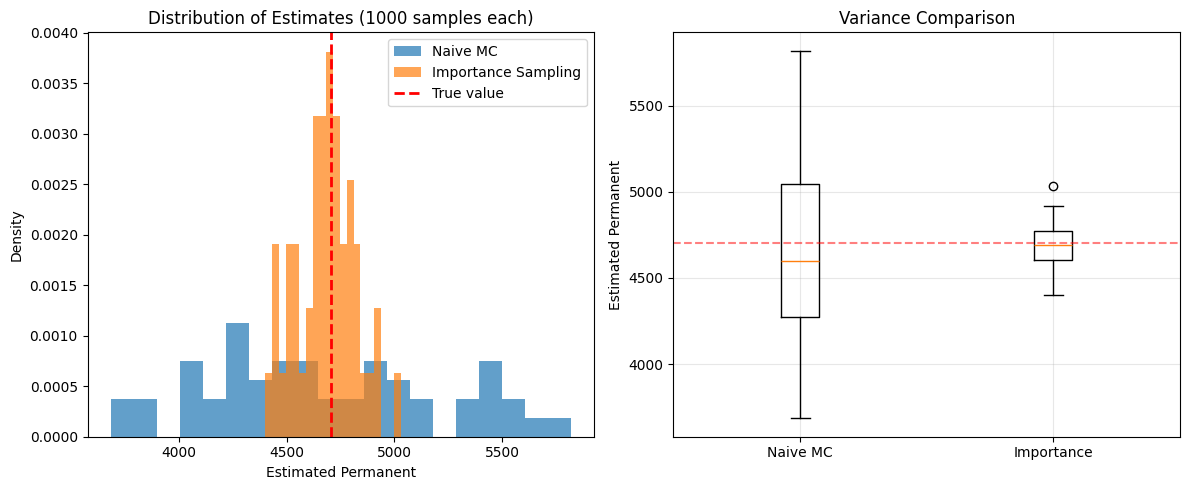


Variance reduction factor: 16.7x
 This means importance sampling needs 17x fewer samples for same accuracy!


In [7]:
# Compare distributions of estimates
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution plots
axes[0].hist(naive_results, bins=20, alpha=0.7, label='Naive MC', density=True)
axes[0].hist(importance_results, bins=20, alpha=0.7, label='Importance Sampling', density=True)
axes[0].axvline(true_perm, color='red', linestyle='--', linewidth=2, label='True value')
axes[0].set_xlabel('Estimated Permanent')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Estimates (1000 samples each)')
axes[0].legend()

# Box plot for variance comparison
axes[1].boxplot([naive_results, importance_results], labels=['Naive MC', 'Importance'])
axes[1].axhline(true_perm, color='red', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Estimated Permanent')
axes[1].set_title('Variance Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate variance reduction
variance_reduction = np.var(naive_results) / np.var(importance_results)
print(f"\nVariance reduction factor: {variance_reduction:.1f}x")
print(f" This means importance sampling needs {variance_reduction:.0f}x fewer samples for same accuracy!")

## 6. Convergence Analysis: How Fast Do They Converge?

perm [3 8 2 5 0 6 1 7 9 4]
perm [9 5 1 6 2 8 4 0 3 7]
perm [1 6 7 9 2 8 3 5 0 4]
perm [9 0 8 6 2 3 5 7 4 1]
perm [0 9 1 7 2 5 6 3 4 8]
perm [1 6 9 4 2 8 5 3 0 7]
perm [7 2 0 4 5 6 9 3 8 1]
perm [5 2 0 3 4 9 7 6 1 8]
perm [0 8 5 4 9 6 2 7 3 1]
perm [6 0 8 4 5 2 7 1 3 9]
perm [1 8 3 9 7 6 2 5 4 0]
perm [5 7 4 1 2 6 3 9 0 8]
perm [1 9 2 7 3 4 5 8 0 6]
perm [7 3 8 0 1 4 9 5 2 6]
perm [9 3 8 7 2 4 1 0 5 6]
perm [8 5 7 6 9 4 0 1 2 3]
perm [4 2 8 3 7 9 0 1 5 6]
perm [8 7 5 9 1 2 6 4 0 3]
perm [2 1 9 8 7 0 4 3 5 6]
perm [8 5 1 2 6 7 4 0 9 3]
perm [3 4 5 2 8 9 0 7 1 6]
perm [5 1 7 8 3 0 9 2 4 6]
perm [4 2 9 0 5 7 8 6 1 3]
perm [7 3 1 5 4 0 2 9 8 6]
perm [6 3 1 5 8 7 4 2 9 0]
perm [4 6 5 1 0 9 3 2 8 7]
perm [0 8 4 7 2 6 3 1 5 9]
perm [6 9 1 4 0 8 7 5 2 3]
perm [4 7 9 0 5 8 1 2 6 3]
perm [0 8 1 6 2 3 4 7 9 5]
perm [7 5 2 9 1 6 4 0 8 3]
perm [7 0 3 1 4 8 9 6 2 5]
perm [7 1 9 2 8 3 6 0 4 5]
perm [7 8 2 1 3 6 0 5 9 4]
perm [0 2 7 1 3 4 6 5 8 9]
perm [7 3 1 4 8 6 2 0 5 9]
perm [8 0 5 9 6 7 2 4 3 1]
p

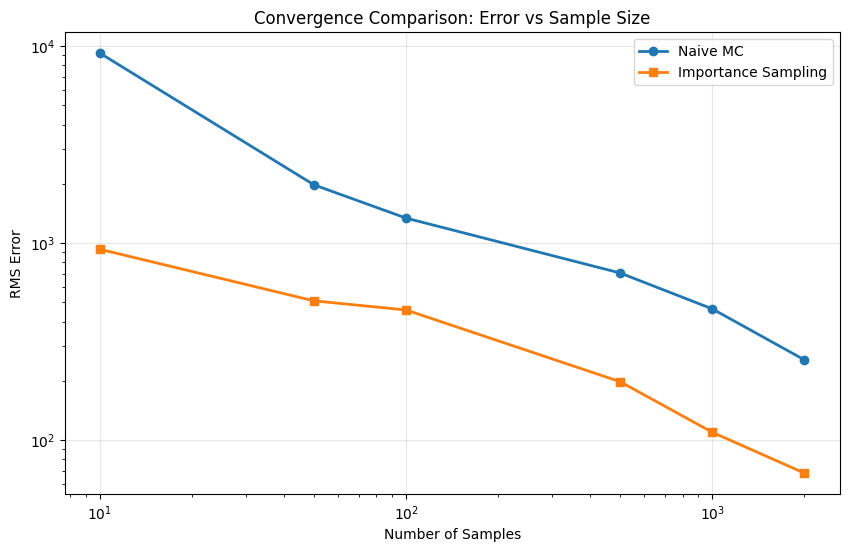

In [8]:
# Test convergence with different sample sizes
sample_sizes = [10, 50, 100, 500, 1000, 2000]
naive_errors = []
importance_errors = []

for n_samples in sample_sizes:
    # Run each method 20 times
    naive_ests = [permanent_naive_mc(A, n_samples) for _ in range(20)]
    importance_ests = [permanent_importance_sampling(A, n_samples) for _ in range(20)]
    
    # Calculate RMS error
    naive_errors.append(np.sqrt(np.mean((np.array(naive_ests) - true_perm)**2)))
    importance_errors.append(np.sqrt(np.mean((np.array(importance_ests) - true_perm)**2)))

# Plot convergence
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, naive_errors, 'o-', label='Naive MC', linewidth=2)
plt.loglog(sample_sizes, importance_errors, 's-', label='Importance Sampling', linewidth=2)
plt.xlabel('Number of Samples')
plt.ylabel('RMS Error')
plt.title('Convergence Comparison: Error vs Sample Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## 7. Testing on a Challenging Matrix

Let's test on a matrix where importance sampling really shines:

In [9]:

# Create a diagonal-dominant matrix (challenging for naive MC)
n = 10
A_hard = np.ones((n, n)) * 0.1
np.fill_diagonal(A_hard, 2)

# This is still small enough to compute exactly
true_perm_hard = permanent_exact(A_hard)

# Compare methods
n_trials = 100
n_samples = 500

naive_hard = [permanent_naive_mc(A_hard, n_samples) for _ in range(n_trials)]
importance_hard = [permanent_importance_sampling(A_hard, n_samples) for _ in range(n_trials)]

print("Diagonal-Dominant Matrix (10 by 10):")
print("="*40)
print(f"True permanent: {true_perm_hard:.2f}")
print(f"\nNaive MC:")
print(f"  Mean:  {np.mean(naive_hard):.2f}")
print(f"  Std:   {np.std(naive_hard):.2f}")
print(f"  Error: {abs(np.mean(naive_hard) - true_perm_hard):.2f}")
print(f"\nImportance Sampling:")
print(f"  Mean:  {np.mean(importance_hard):.2f}")
print(f"  Std:   {np.std(importance_hard):.2f}")
print(f"  Error: {abs(np.mean(importance_hard) - true_perm_hard):.2f}")


perm [2 8 9 4 5 6 7 3 0 1]
perm [8 9 4 3 0 5 6 2 7 1]
perm [2 6 5 3 4 0 7 1 8 9]
perm [1 2 4 3 6 9 8 0 5 7]
perm [4 6 3 0 1 8 7 2 5 9]
perm [5 8 3 7 6 4 2 9 0 1]
perm [3 6 5 2 7 0 9 4 8 1]
perm [4 8 3 5 7 0 2 6 1 9]
perm [7 9 1 2 3 8 5 6 4 0]
perm [5 9 3 1 4 2 7 6 8 0]
perm [6 1 9 7 8 0 2 5 3 4]
perm [4 1 6 8 0 7 5 3 2 9]
perm [3 1 2 4 6 7 9 5 0 8]
perm [5 6 4 8 1 2 9 3 0 7]
perm [0 5 9 2 3 7 1 4 8 6]
perm [9 3 5 4 0 8 1 2 6 7]
perm [5 6 0 9 3 8 1 7 2 4]
perm [7 5 2 0 4 9 6 3 8 1]
perm [9 1 4 3 0 8 6 2 5 7]
perm [0 9 1 5 4 6 2 7 8 3]
perm [1 2 4 5 8 9 7 3 0 6]
perm [3 8 7 5 2 9 1 4 6 0]
perm [5 9 3 4 2 0 1 6 8 7]
perm [6 4 7 1 8 9 5 2 3 0]
perm [2 0 8 6 4 7 3 1 9 5]
perm [4 3 1 7 6 8 9 5 2 0]
perm [2 4 8 9 6 1 0 7 5 3]
perm [4 0 8 1 5 2 7 9 6 3]
perm [7 4 5 8 0 6 1 9 2 3]
perm [7 9 4 1 2 0 8 6 5 3]
perm [0 3 1 5 2 6 4 7 8 9]
perm [0 5 8 4 7 1 3 9 6 2]
perm [7 4 6 9 3 5 2 0 8 1]
perm [2 3 4 8 6 9 1 5 7 0]
perm [2 0 5 7 8 1 9 3 6 4]
perm [4 2 6 1 7 3 0 9 8 5]
perm [3 7 1 5 8 9 4 2 0 6]
p